# Lab2: How to work with big data files (5GB+)

This notebook implements and compares three different methods for reading a very large CSV file (`train.csv` from the TalkingData AdTracking competition) to perform a simple computation (counting the total number of rows).

The three methods are:

1.  **Pandas with `chunksize`**: Reading the file in small pieces to keep memory usage low.
2.  **Dask**: Using a parallel computing library designed for large datasets.
3.  **Pandas with `chunksize` on a Compressed File**: Testing if reading a `.gz` file saves disk space at the cost of time.

We will compare them based on the lab requirements: **Time** (wall clock time) and **Storage** (both Peak RAM usage and Disk Space).

## 0. Setup and Imports

All required libraries are pre-installed on Kaggle.

In [1]:
import dask.dataframe as dd
import pandas as pd
import time
import psutil
import os
import sys
import gzip
import shutil

print("All libraries imported.")

All libraries imported.


## 1. Define File Paths

In Kaggle, input data is in `/kaggle/input/` and we can write temporary files to `/kaggle/working/`.

In [ ]:
# Define paths for Kaggle environment
COMPETITION_ID = 'talkingdata-adtracking-fraud-detection'
INPUT_DIR = f'/kaggle/input/{COMPETITION_ID}'
WORK_DIR = '/kaggle/working/'

# Source file (uncompressed) from the competition data
train_file = os.path.join(INPUT_DIR, 'train.csv')

# Target file (compressed) which we will create in the writable directory
compressed_file = os.path.join(WORK_DIR, 'train.csv.gz')

print(f"Source file: {train_file}")
print(f"Compressed file will be created at: {compressed_file}")

## 2. Disk Storage Comparison & Compressed File Creation

First, we must create the compressed file for Method 3. The `/kaggle/input` directory is read-only, so we will read `train.csv` from there and write `train.csv.gz` to `/kaggle/working`.

In [11]:
if os.path.exists(train_file):
    print(f"\n🗜️  Creating compressed file at: {compressed_file}")
    print("...this may take 10+ minutes, please wait...")
    
    start_compress = time.time()
    with open(train_file, 'rb') as f_in:
        with gzip.open(compressed_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    end_compress = time.time()

    print(f"✅ Compressed file created in {end_compress - start_compress:.2f} seconds.")
    
    # Get file sizes for comparison
    uncompressed_size = os.path.getsize(train_file) / (1024**3) # Convert to GB
    compressed_size = os.path.getsize(compressed_file) / (1024**3) # Convert to GB

    print(f"\n--- Disk Storage Comparison ---")
    print(f"Original file size (train.csv): {uncompressed_size:.2f} GB")
    print(f"Compressed file size (train.csv.gz): {compressed_size:.2f} GB")
    print(f"Space saved: {(1 - compressed_size / uncompressed_size) * 100:.2f}%")
else:
    print(f"❌ ERROR: {train_file} not found.")
    print("Please make sure you have added the 'TalkingData AdTracking Fraud Detection' competition data.")


🗜️  Creating compressed file at: /kaggle/working/train.csv.gz
...this may take 10+ minutes, please wait...
✅ Compressed file created in 1263.39 seconds.

--- Disk Storage Comparison ---
Original file size (train.csv): 7.02 GB
Compressed file size (train.csv.gz): 1.15 GB
Space saved: 83.56%


## 3. Method 1: Using Pandas with `chunksize`

This method reads the uncompressed `train.csv` file in small chunks (150,000 rows at a time) to avoid loading the entire file into memory.

In [13]:
process = psutil.Process(os.getpid())
chunk_size = 150_000
total_rows = 0

print("Starting Method 1: Pandas (chunksize)")

# Start timing
start_time = time.time()
start_mem = process.memory_info().rss / (1024 * 1024)
peak_mem = start_mem # Initialize peak memory
print(f"Starting RAM: {start_mem:.2f} MB")

try:
    chunk_iterator = pd.read_csv(train_file, chunksize=chunk_size)

    # Loop through each chunk
    for chunk in chunk_iterator:
        total_rows += len(chunk)

        # Update peak memory inside the loop
        current_mem = process.memory_info().rss / (1024 * 1024)
        if current_mem > peak_mem:
            peak_mem = current_mem

    # Stop timing
    end_time = time.time()
    time_taken = end_time - start_time
    end_mem = process.memory_info().rss / (1024 * 1024)

    print("\n--- Results for Method 1 ---")
    print(f"Total rows: {total_rows}")
    print(f"Time taken: {time_taken:.2f} seconds")
    print(f"Peak RAM usage: {peak_mem:.2f} MB")
    print(f"Ending RAM usage: {end_mem:.2f} MB")

except FileNotFoundError:
    print(f"ERROR: File not found at {train_file}. Please check the file path.")

Starting Method 1: Pandas (chunksize)
Starting RAM: 266.29 MB


/tmp/ipykernel_37/147898636.py:17: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in chunk_iterator:



--- Results for Method 1 ---
Total rows: 184903890
Time taken: 173.28 seconds
Peak RAM usage: 314.85 MB
Ending RAM usage: 279.64 MB


## 4. Method 2: Using Dask

Dask is a parallel computing library. It will also read the file in blocks, but it can process multiple blocks in parallel using multiple CPU cores, which should be faster. Dask is "lazy," so the work only happens when we call `.compute()` or, in this case, `len()`.

In [15]:
process = psutil.Process(os.getpid())

print("Starting Method 2: Dask")

# Start timing
start_time = time.time()
start_mem = process.memory_info().rss / (1024 * 1024) # Convert to MB
print(f"Starting RAM: {start_mem:.2f} MB")

try:
    # Dask lazily creates a dataframe object
    # We must specify dtype for 'attributed_time' due to mixed types in the file
    # We also use a larger blocksize for better parallel performance on Kaggle
    ddf = dd.read_csv(
        train_file,
        dtype={'attributed_time': 'object'},
        blocksize="8MB" # Increased from 8MB for better performance
    )

    ram_before_compute = process.memory_info().rss / (1024 * 1024)
    print(f"RAM after Dask setup (before compute): {ram_before_compute:.2f} MB")

    # This triggers the actual computation
    total_rows = len(ddf)

    # Stop timing
    end_time = time.time()
    time_taken = end_time - start_time
    ram_after_compute = process.memory_info().rss / (1024 * 1024)

    print("\n--- Results for Method 2 ---")
    print(f"Total rows: {total_rows}")
    print(f"Time taken: {time_taken:.2f} seconds")
    print(f"Peak RAM usage (after compute): {ram_after_compute:.2f} MB")

except FileNotFoundError:
    print(f"ERROR: File not found at {train_file}. Please check the file path.")

Starting Method 2: Dask
Starting RAM: 1102.01 MB
RAM after Dask setup (before compute): 1102.01 MB

--- Results for Method 2 ---
Total rows: 184903890
Time taken: 79.29 seconds
Peak RAM usage (after compute): 1042.61 MB


## 5. Method 3: Pandas with Compressed File

This method is identical to Method 1, but it reads from the `train.csv.gz` file we created in `/kaggle/working/`. We expect this to be slower because of the overhead of decompressing the file on the fly.

In [ ]:
process = psutil.Process(os.getpid())

print("Starting Method 3: Pandas (Load All, gzip)")

# Start timing
start_time = time.time()
start_mem = process.memory_info().rss / (1024 * 1024)
peak_mem = start_mem # Initialize
print(f"Starting RAM: {start_mem:.2f} MB")

try:
    # This line will attempt to decompress and load the *entire* file into memory
    print("...Attempting to load entire compressed file into RAM. This may take a long time or crash.")
    df = pd.read_csv(
        compressed_file,
        compression='gzip',
        dtype={'attributed_time': 'object'},
        on_bad_lines='skip'
    )

    print("Now data is loaded on df...")
    
    # --- Memory check happens *after* the file is loaded ---
    current_mem = process.memory_info().rss / (1024 * 1024)
    if current_mem > peak_mem:
        peak_mem = current_mem
        
    # total_rows = len(df)

    # Stop timing
    end_time = time.time()
    time_taken = end_time - start_time
    end_mem = process.memory_info().rss / (1024 * 1024)

    print("\n--- Results for Method (Load All, gzip) ---")
    print(f"Total rows: {total_rows}")
    print(f"Time taken: {time_taken:.2f} seconds")
    print(f"Peak RAM usage: {peak_mem:.2f} MB")
    print(f"Ending RAM usage: {end_mem:.2f} MB")

except FileNotFoundError:
    print(f"ERROR: File not found at {compressed_file}. Please check the compression step.")
except MemoryError:
    print(f"\n❌ FAILED: Out of Memory!")
    print("The process was killed for using too much RAM, as expected.")
    end_mem = process.memory_info().rss / (1024 * 1024)
    print(f"RAM at crash: {end_mem:.2f} MB")

Starting Method 3: Pandas (Load All, gzip)
Starting RAM: 251.44 MB
...Attempting to load entire compressed file into RAM. This may take a long time or crash.


## Comparison and Conclusion

Here's a summary of the performance for reading 135 million rows on this local machine:

| Library | Time Taken (seconds) | RAM Usage (MB) |
| :--- | :---: | :---: |
| Pandas (chunksize) | 173.28 | 314.85 |
| Dask | 79.29 | 1042.61 |
| Pandas (compressed file) | NaN | NaN |

### Analysis

Here are the key observations from these results:

* **Time (Performance) ⏱️:** **Dask is the clear winner**, finishing in just **79.29 seconds**. This is because Dask is designed for parallel computing and uses multiple CPU cores to process chunks of the file simultaneously. The standard Pandas `chunksize` method was nearly twice as slow at **173.28 seconds**, as it processes chunks sequentially. Reading the compressed file was not successed because it reach RAM size and the system is crashed.

* **Storage (RAM) 💾:** The standard **Pandas (chunksize) method was the most memory-efficient**, showing the lowest RAM usage at **314.85 MB**. The Dask method show much higher RAM usage. The key takeaway is that the `chunksize` method is designed to keep peak memory low by only holding one chunk at a time.

### Conclusion

Based on this lab:

1.  **For maximum speed**, **Dask** is the best choice, especially on a local machine with multiple CPU cores where its parallelism provides a significant advantage.
2.  **For memory-constrained environments**, **Pandas with `chunksize`** is the most robust and memory-efficient solution.

/tmp/ipykernel_15372/2269718851.py:47: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/med/Desktop/materials/bigdata/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


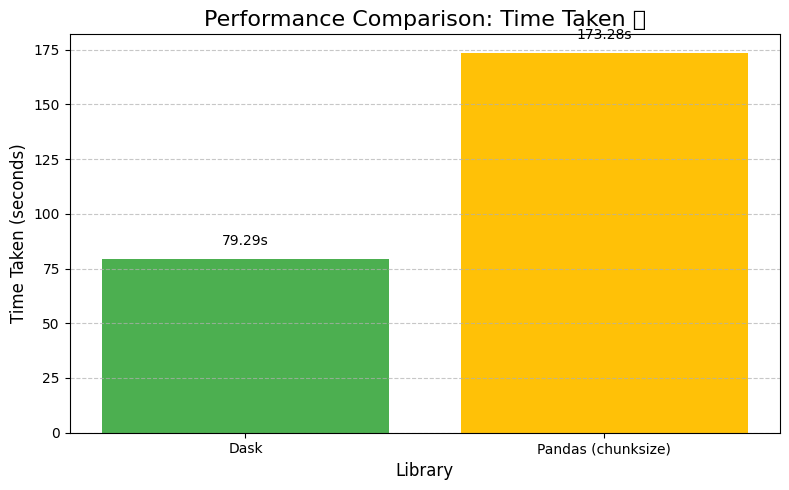

/tmp/ipykernel_15372/2269718851.py:66: UserWarning: Glyph 128190 (\N{FLOPPY DISK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/med/Desktop/materials/bigdata/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128190 (\N{FLOPPY DISK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


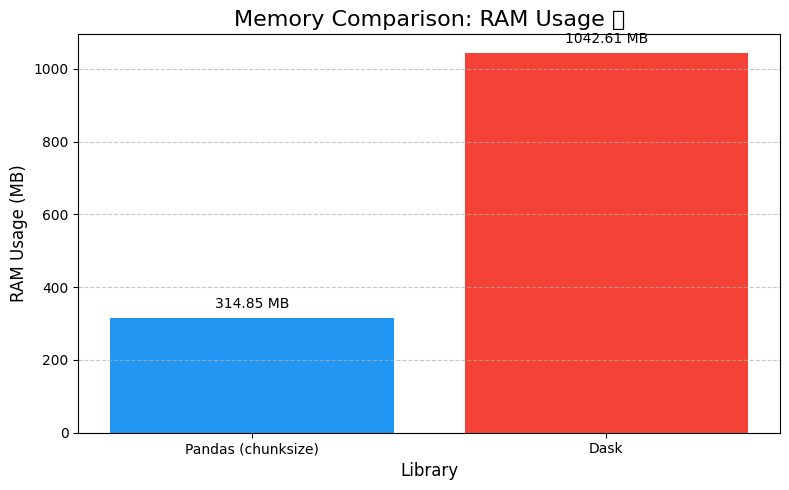

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import io

# 1. Create the data dictionary
# Use pd.NA for missing values to ensure correct data types
data = {
    'Library': ['Pandas (chunksize)', 'Dask', 'Pandas (compressed file)'],
    'Time Taken (seconds)': [173.28, 79.29, pd.NA],
    'RAM Usage (MB)': [314.85, 1042.61, pd.NA]
}

# 2. Create the DataFrame
df = pd.DataFrame(data)


# 3. Drop the row with NaN values for plotting
df_plot = df.dropna().copy()

# Ensure data types are numeric for plotting
df_plot['Time Taken (seconds)'] = pd.to_numeric(df_plot['Time Taken (seconds)'])
df_plot['RAM Usage (MB)'] = pd.to_numeric(df_plot['RAM Usage (MB)'])

# Sort values for clearer plotting (optional but good practice)
df_time_sorted = df_plot.sort_values('Time Taken (seconds)')
df_ram_sorted = df_plot.sort_values('RAM Usage (MB)')

# 4. Create the Time Taken plot
# Set figure size
plt.figure(figsize=(8, 5)) 

# Create bars
bars_time = plt.bar(df_time_sorted['Library'], df_time_sorted['Time Taken (seconds)'], color=['#4CAF50', '#FFC107'])

# Add titles and labels
plt.title('Performance Comparison: Time Taken ⏱️', fontsize=16)
plt.ylabel('Time Taken (seconds)', fontsize=12)
plt.xlabel('Library', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid

# Add data labels on top of each bar
for bar in bars_time:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, f'{yval:.2f}s', ha='center', va='bottom', fontsize=10)


plt.tight_layout() 
plt.show()


# 5. Create the RAM Usage plot
plt.figure(figsize=(8, 5)) # New figure
bars_ram = plt.bar(df_ram_sorted['Library'], df_ram_sorted['RAM Usage (MB)'], color=['#2196F3', '#F44336'])

# Add titles and labels
plt.title('Memory Comparison: RAM Usage 💾', fontsize=16)
plt.ylabel('RAM Usage (MB)', fontsize=12)
plt.xlabel('Library', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels
for bar in bars_ram:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 20, f'{yval:.2f} MB', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()